# Data 620: Homework 2: Graph Visualization
### Aaron Grzasko
### 9/15/2018

## Instructions

*1) Load a graph database of your choosing from the web.  If the network dataset is large, feel free to use a small subset of nodes and edges.*  
*2) Create basic analysis on graph, including graph diameter and at least one additional metric.*  
*3) Use a visualization tool to display information*  
*4) Record a short video and submit link as part of homework submission*


## 1) Load Graph Database

### Libraries

First, let's load the relevant libraries and set up the Python environment.

In [1]:
# load libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import warnings
from IPython.display import Image
import urllib.request
from gephistreamer import graph
from gephistreamer import streamer

# settings
%matplotlib inline
warnings.filterwarnings('ignore')

### Data Description

Data for this assignment were retrieved from [sociopatterns.org](http://sociopatterns.org). The landing page for the data set can be found [here](http://www.sociopatterns.org/datasets/high-school-dynamic-contact-networks/).

The data set indicates interactions between pairs of French high school students and teachers in Marseilles, France.  The data were collected for students of three classes over the course of four days in December 2011.

The website describes the following four fields in the *highschool_2011.csv* file:  
* *time*- the time (in seconds) the interaction took place, given in intervals [t-20, t]
* *id1* - unique identifier for person 1.
* *id2* - unique identifier for person 2
* *class1* - the class of person 1.
* *class2* - the class of person 2.


This data also has an accompanying metafile, *metadata_2011.txt*, with the following fields:
* *id* - unique identifier of student/teacher
* *class* - class of student or teacher
* *gender* - gender of individual

### Get and Explore Data

First, let's download the relevant data files directly from the [sociopatterns.org](http://sociopatterns.org).

In [11]:
# downlaod data from web
url1 = 'http://www.sociopatterns.org/wp-content/uploads/2014/08/highschool_2011.csv.gz'
url2 = 'http://www.sociopatterns.org/wp-content/uploads/2015/09/metadata_2011.txt'
file1 = urllib.request.urlretrieve(url1,'highschool_2011.csv.gz' )
file2 = urllib.request.urlretrieve(url2, 'metadata_2011.txt')

**Highschool File**

Let's explore the main data file, *highschool_2001.csv*:

In [60]:
# header values
head = ['time', 'id1', 'id2', 'class1', 'class2']

# decompress and read highschool file as DataFrame
df = pd.read_csv('highschool_2011.csv.gz', compression='gzip', names=head, sep='\t', quotechar='"')

# print data shape
print("Data Shape:")  
print(df.shape)
print("#"*50)

# print head of data frame
print("Data Frame head: ")
print(df.head())
print("#"*50)

# explore data types
print("Data Types:")
print(df.info())
print("#"*50)

# summary of numerical columns
print("Summary of numeric data:")
print(df.describe())
print("#"*50)

# table of class1 field values and corresponding counts
print("Class 1: values and counts: ")
print(df.groupby('class1').count().iloc[:,0])
print("#"*50)

# table of class2 field values and corresponding counts
print("Class 2: values and counts: ")
print(df.groupby('class2').count().iloc[:,0])


Data Shape:
(28561, 5)
##################################################
Data Frame head: 
    time  id1  id2 class1 class2
0  54120   26   66     PC     PC
1  54140   26   66     PC     PC
2  54160   24   25     PC     PC
3  54160  100   37     PC     PC
4  54180   37   57     PC    PC*
##################################################
Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28561 entries, 0 to 28560
Data columns (total 5 columns):
time      28561 non-null int64
id1       28561 non-null int64
id2       28561 non-null int64
class1    28561 non-null object
class2    28561 non-null object
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None
##################################################
Summary of numeric data:
                time          id1           id2
count   28561.000000  28561.00000  28561.000000
mean   178437.273205     55.45114     60.984034
std     97479.134736     30.79300     36.557411
min     54120.000000      1.00000      1.000000
25%     765

We see the data file is fairly large with 58,561 interactions pairs captured.  We also see that students are bucketed in one of three unique classes, with a fourth class reserved for teachers.  

**Meta File**

Let's briefly examine the *metadata_2011.txt* file.

In [299]:
# header values
head = ['id', 'class', 'gender']

# read meta file as DataFrame
df_meta = pd.read_csv('metadata_2011.txt', sep = '\t', names = head)


# print data shape
print("Data Meta Shape:")  
print(df_meta.shape)
print("#"*50)

# print head of data frame
print("Data Meta head: ")
print(df_meta.head())
print("#"*50)

# explore data types
print("Data Meta Types:")
print(df_meta.info())
print("#"*50)

# summary of numerical columns
print("Summary of numeric data:")
print(df_meta.describe())
print("#"*50)

# table of class field values and corresponding counts
print("Class: values and counts: ")
print(df_meta.groupby('class').count().iloc[:,0])
print("#"*50)

# table of gender field values and corresponding counts
print("Gedner: values and counts: ")
print(df_meta.groupby('gender').count().iloc[:,0])



Data Meta Shape:
(126, 3)
##################################################
Data Meta head: 
    id class gender
0   28    PC      F
1  103    PC      F
2   34  PSI*      M
3   81    PC      M
4   56    PC      F
##################################################
Data Meta Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
id        126 non-null int64
class     126 non-null object
gender    126 non-null object
dtypes: int64(1), object(2)
memory usage: 3.0+ KB
None
##################################################
Summary of numeric data:
               id
count  126.000000
mean    63.500000
std     36.517119
min      1.000000
25%     32.250000
50%     63.500000
75%     94.750000
max    126.000000
##################################################
Class: values and counts: 
class
PC         31
PC*        45
PSI*       42
teacher     8
Name: id, dtype: int64
##################################################
Gedner: values and

The meta file provides one additional piece of information not available in the main data set: gender.  We also see that the meta file describes information about 126 unique individuals.

### Data Wrangling

Instead tracking pairs of interactions at each time interval, we'll summarize the data set so that we'll sum the number of interactions that were recording over the entire four day period.

In [142]:
# summarize by id1/id2 interactions, anc count number of interactions recording
df_mod = pd.DataFrame(df.groupby(['id1', 'id2']).count().iloc[:,0])
df_mod = test.reset_index()

## 2) Graph Analysis

### Graph Metrics - Python

Below, we produce a handful of graph statistics:  
* number of nodes  
* number of edges  
* graph diameter  
* minimum graph degree
* maximum graph degree
* top 10 nodes, sorted by degree in descending order
* plot of distriubtion of degree centrality

number of edges: 1710

number of nodes: 126

graph diameter: 4

minimum graph degree: 2

maxmum graph degree: 55

Top 10 nodes with corresponding degrees:
[(16, 55), (11, 54), (43, 53), (51, 51), (9, 50), (69, 50), (12, 48), (24, 47), (40, 47)]

characteristics of top 10 most connected nodes:
     id class gender
7    24    PC      M
40   16   PC*      M
45   51   PC*      F
54    9  PSI*      M
69   43   PC*      M
70   11   PC*      F
71   40   PC*      F
88   12   PC*      M
112  69   PC*      M

Closeness Centrality:


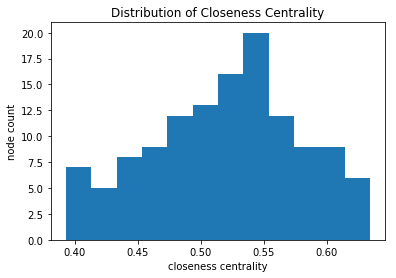

In [214]:
# number of edges
print("number of edges: " + str(G.number_of_edges()))

# number of nodes
print("\nnumber of nodes: " + str(G.number_of_nodes()))

# graph diameter
print("\ngraph diameter: " + str(nx.diameter(G)))

# degree statistics
deg=nx.degree(G)
print("\nminimum graph degree: " + str(min(deg.values())))
print("\nmaxmum graph degree: " + str(max(deg.values())))

# top 10 nodes in terms of degree
deg10 = [(k, deg[k]) for k in sorted(deg, key=deg.get, reverse=True)][0:9]
print("\nTop 10 nodes with corresponding degrees:")
print(deg10)
deg10_nodes = [x[0] for x in deg10]
print('\ncharacteristics of top 10 most connected nodes:')
print(df_meta[df_meta['id'].isin(deg10_nodes)])

# closeness centrality
print("\nCloseness Centrality:")
cc = nx.closeness_centrality(G)
plt.hist(([cc[i] for i in cc]),12)
plt.xlabel('closeness centrality')
plt.ylabel('node count')
plt.title('Distribution of Closeness Centrality')
plt.show()

### Gephi Graphi Metrics

Before we visualize the data in Gephi, we need to send the node and edge data to the Gephi Software.  The scripts below allow us to construct the network directly from Python.  The Master server must be turned on wihtin Gephi for the scripts to work properly.

In [289]:
# create stream object, gephi
stream = streamer.Streamer(streamer.GephiWS())

In [290]:
# add nodes to gephi, include class and gender info
for i in range(len(df_meta)):
    mynode = graph.Node(str(df_meta.iloc[i,0]), clss=df_meta.iloc[i,1], gender=df_meta.iloc[i,2])
    stream.add_node(mynode)

# add edges to gephi, include number of contacts between each node pair
for i,j in edges:
    node1 = graph.Node(str(i))
    node2 = graph.Node(str(j))
    myedge = graph.Edge(node1, node2, False, contacts=int(df_mod[(df_mod['id1']==i) & (df_mod['id2']==j)].iloc[0,2]))
    stream.add_edge(myedge)
  


Below are a variety of metrics output from the Gephi software:

In [294]:
# image of graph metrics from Gephi
url = 'https://raw.githubusercontent.com/spitakiss/Data620/master/hw2_wk3/GephiMetrics.PNG'
Image(url=url)


## 3) Visualize Data

### NetworkX Visual Summary

Here is visual summary of our network, using the networkx python library:

We already produced a visulization of the network using the networkx library.  Now, we will will produce a visualization in Gephi.

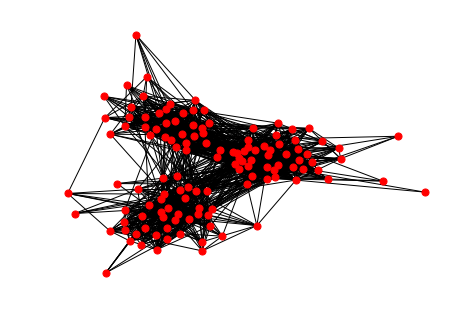

In [147]:
# save each interaction pair as edge
edges = [(df_mod.iloc[i,0],df_mod.iloc[i,1]) for i in range(len(df_mod))]

# unique node identifiers
nodes = np.unique(np.concatenate((df_mod['id1'],df_mod['id2'])))

# draw graph
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, node_size=50)

From the graph above, we see that a few dense clusters of nodes (i.e. individuals) that are highly connected. We also see a small number of nodes that have very few connections with other nodes.

### Gephi Visual Summary

Let's look at various network visualization produced from the Gephi Software.  In the graph below, we colored the nodes to indicate gender.  It appears that each gender has tendency to cluster more closely to individuals of the same sex.    

In [300]:
# image of graph from Gephi - node colors indicate gender
url = 'https://raw.githubusercontent.com/spitakiss/Data620/master/hw2_wk3/GephiGraph_Gender.PNG'
Image(url=url)


Now let's look at the same network, but with node colors broken out by the class of each individual.  Here we see that individuals in the same class are much more likely to interact with other students in the same class.  We also see that teachers (see the turquoise nodes) appear to be less connected compared to the typical student.  

In [296]:
# image of graph from Gephi - node colors indicate class
url = 'https://raw.githubusercontent.com/spitakiss/Data620/master/hw2_wk3/GephiGraph_Class.PNG'
Image(url=url)

Finally, we implement a heat map on the edge color intensity.  Darker colors represent more frequent interaction between pairs of individuals.  Interestingly, we only see a handful of student pairs where interaction was extremely frequent over the course of the four days in the measurement period.  

In [297]:
# image of graph from Gephi - edge colors vary by number of interactions between nodes
url = 'https://raw.githubusercontent.com/spitakiss/Data620/master/hw2_wk3/GephiGraph_contacts.PNG'
Image(url=url)

## Screencast-o-matic Commentary

Please refer to my visual/audio commentary here:
http://youtu.be/iv7ujB67sV8?hd=1

## References

* [Graph Data](http://www.sociopatterns.org/datasets/high-school-dynamic-contact-networks/). This data was part of the following study: 
J. Fournet, A. Barrat, Contact patterns among high school students,PLoS ONE 9(9):e107878 (2014).  The data were made available as part of a collaboration with sociopatterns.org  
* [GephiStreamer Documentation](https://github.com/totetmatt/GephiStreamer/blob/master/README.md)
* [How to create Gephi graphs from Ptyhon](https://www.codesd.com/item/how-to-create-gephi-network-graphs-from-python.html)
* Tsvetovat, Maksim, and Alexander Kouznetsov. *Social Network Analysis for Startups*. OReilly, 2012, pp 25-50.  
* [NetworkX Documentation](https://networkx.github.io/documentation/networkx-1.9.1/)
* [My Github Repo](https://github.com/spitakiss/Data620/tree/master/hw2_wk3)